# Kickstarter Projects 
### CSC 478 Final Project
#### Synopsis:
* The purpose of this project is to predict whether a kickstarter campaign will fail, succeed, or cancel based on the available information available [here](https://raw.githubusercontent.com/stfox13/CSC478FinalProject/master/Data/ks-projects-201801.csv).
* We will use an array of machine learning algorithms, including KNN, Linear Regression, Logistic Regression, and / or SVM to find the most accurate model.

#### Contributors:
* [Rebecca Tung (1448196)](https://github.com/rtungus)
* [Sidney Fox (1524992)](https://github.com/stfox13)

#### Data Dictionary:


##### Content
You'll find most useful data for project analysis. Columns are self explanatory except:

1. usd_pledged: conversion in US dollars of the pledged column (conversion done by kickstarter).

2. usd pledge real: conversion in US dollars of the pledged column (conversion from Fixer.io API).

3. usd goal real: conversion in US dollars of the goal column (conversion from Fixer.io API).


|Sequence Number|Column Name|Data Type|
|:---|:---|:---|
|1|ID|Numeric|
|2|name|String|
|3|category|String|
|4|main_category|String|
|5|currency|String|
|6|deadline|DateTime|
|7|goal|Numeric|
|8|launched|DateTime|
|9|pledged|Numeric|
|10|state|String|
|11|backers|Numeric|
|12|country|String|
|13|usd pledged|Numeric|
|14|usd_pledged_real|Numeric|
|15|usd_goal_real|Numeric|

## Libraries used through the project:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
#import plotly.plotly as py
import numpy as np
import pandas as pd
import seaborn as sns
import os
import math
import requests
import datetime as dt
import matplotlib as mpl
import io
from pandas import Series, DataFrame
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn import svm
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
#Set graph size
mpl.rcParams['figure.figsize'] = (5,5)

In [4]:
np.set_printoptions(suppress=True)

In [5]:
def roundup(x, y):
    #return int(math.ceil(x / float(y))) * y
    return int(math.ceil(x / y) * y)

## Load raw data as Pandas DataFrame:

In [6]:
url = 'https://raw.githubusercontent.com/stfox13/CSC478FinalProject/master/Data/ks-projects-201801.csv'
kickproj_org= pd.read_csv(url)
len(kickproj_org)

378661

## Define Reuseful Function

In [7]:
#Define a fuction to print and plot confusin matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass
#   print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [8]:
#Define a fuction to calculate and print TP, TN, FP, and FN for each category
def show_statistics(test_y, y_pred, matrix):
    TP = np.diag(matrix)
    FP = np.sum(matrix, axis=0) - TP
    FN = np.sum(matrix, axis=1) - TP
    TN = []
    for i in range(len(matrix)):
        temp = np.delete(matrix, i, 0)    # delete ith row
        temp = np.delete(temp, i, 1)  # delete ith column
        TN.append(sum(sum(temp)))    
    temp_dic = {'TP': TP, 'FP' : FP, 
                'TN' : TN, 'FN' : FN}
    scoreMatrix = DataFrame.from_dict(temp_dic)
    #print "TP, TN, FP, FN for each cateory: "
    return scoreMatrix

In [9]:
# Define a fuction to print F1 Score for each class and global (micro)
def formatResult(preResult, columnNames):  
    resultDF = DataFrame(preResult.values(), columns=columnNames, index=preResult.keys())
    resultDF.loc['sum'] = np.sum(preResult.values(), axis=0)
    resultDF['Sum of Class F1'] = np.append(np.sum(preResult.values(), axis=1), np.NaN)
    return resultDF

In [10]:
#######KNN############
#Define a function to run KNeighborsClassifier with different n_neighbors and store f1 score
def runKNN(trainX, trainY, testX, testY, number, f1_only = False, trainSetName = '', dic_result_knn = {}):
    i = 3
    cls = KNeighborsClassifier(n_neighbors=i)
    while i <= number:
        #print i
        cls = KNeighborsClassifier(n_neighbors=i)
        cls.fit(trainX, trainY)
        predY = cls.predict(testX)
        result = f1_score(testY, predY, average=None).round(2)
        result = np.append(result, f1_score(testY, predY, average='micro').round(2))
        
        #print results
        dic_result_knn['N=' + str(i) +'-' + trainSetName] = result
        #print "n_neighbors = " + str(i) + " : " + result
        i = i + 2
    return dic_result_knn

In [11]:
#######LogisticRegression############
# Define a function to run LogisticRegression with different class_weight settings and store f1 score
def runLogistic(trainX, trainY, testX, testY, f1_only = False, trainSetName = '', dic_result_log = {}):
    cls = LogisticRegression() 
    cls.fit(trainX, trainY)
    predY = cls.predict(testX)
    result = f1_score(testY, predY, average=None).round(2)
    result = np.append(result, f1_score(testY, predY, average='micro').round(2))
    #print results
    dic_result_log['CWeight = None - ' + trainSetName] = result 
    
    cls = LogisticRegression(class_weight='balanced')
    cls.fit(trainX, trainY)
    predY = cls.predict(testX)
    result = f1_score(testY, predY, average=None).round(2)
    result = np.append(result, f1_score(testY, predY, average='micro').round(2))
    #print results
    dic_result_log['CWeight = balanced - ' + trainSetName] = result   
    return dic_result_log

In [12]:
#######SVM############
# Define a function to run SVM with different kernel settings and store f1 score
def runSVM(trainX, trainY, testX, testY, f1_only = False, trainSetName = '', dic_result_log = {}):
    
    C = 1.0 # SVM regularization parameter
    svc = svm.SVC(kernel='linear', C=C, decision_function_shape='ovr').fit(trainX, trainY)
    predY = svc.predict(X_plot)        
    result = f1_score(testY, predY, average=None).round(2)
    result = np.append(result, f1_score(testY, predY, average='micro').round(2))
    print results
    dic_result_log['SVCKernel = linear - ' + trainSetName] = result 
    
    svc = svm.SVC(kernel='rbf', C=C, decision_function_shape='ovr').fit(trainX, trainY)
    predY = svc.predict(X_plot)        
    result = f1_score(testY, predY, average=None).round(2)
    result = np.append(result, f1_score(testY, predY, average='micro').round(2))
    print results
    dic_result_log['SVCKernel = rbf - ' + trainSetName] = result 
    
    #svc = svm.SVC(kernel='poly', C=C, decision_function_shape='ovr').fit(trainX, trainY)
    #predY = svc.predict(X_plot)        
    #result = f1_score(testY, predY, average=None).round(2)
    #result = np.append(result, f1_score(testY, predY, average='micro').round(2))
    #print results
    #dic_result_log['SVCKernel = poly - ' + trainSetName] = result 
    
    return dic_result_log

In [13]:
#Create a function to create colunm names
def createColNmae(features, name):
    i = 1
    d = {}
    for i in range(features):
        d[i+1] = '%s%d' % (name, i+1)
        #d[i+1]=name + str(i+1)
    return d.values()

na = 'country'
names = createColNmae (4, na)
names

['country1', 'country2', 'country3', 'country4']

## Check the Y data:

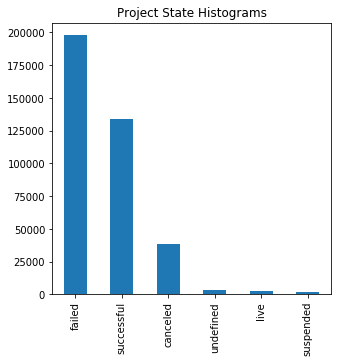

In [14]:
#Plot histogram
kickproj_org['state'].value_counts().plot(kind='bar', title='Project State Histograms')

### Drop projects when the state is equal to "undefined":

375099

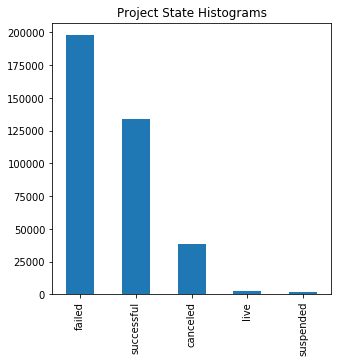

In [15]:
# Remove state = 'undefined'
kickproj = kickproj_org[kickproj_org['state'] != 'undefined']
len(kickproj)
kickproj['state'].value_counts().plot(kind='bar', title='Project State Histograms')

In [16]:
kickproj.head(5)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


#### Since we have the goal and pledge amounts converted to US dollars (usd), we will drop the original goal and pledged columns:

In [17]:
#kickproj = kickproj[kickproj.columns.difference(['goal','pledged','usd pledged'])]
kickproj = kickproj.drop(['goal','pledged','usd pledged'], axis=1)
len(kickproj)
kickproj.head(5)

375099

,ID,name,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,failed,0,GB,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,failed,15,US,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,failed,3,US,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,2012-03-17 03:24:11,failed,1,US,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,2015-07-04 08:35:03,canceled,14,US,1283.0,19500.00


## Check the X data:

In [18]:
kickproj.describe()

,ID,backers,usd_pledged_real,usd_goal_real
count,3.750990e+05,375099.000000,3.750990e+05,3.750990e+05
mean,1.074632e+09,106.620436,9.123935e+03,4.584708e+04
std,6.191294e+08,911.423593,9.140142e+04,1.158404e+06
min,5.971000e+03,0.000000,0.000000e+00,1.000000e-02
25%,5.380782e+08,2.000000,3.100000e+01,2.000000e+03
50%,1.075217e+09,12.000000,6.250000e+02,5.500000e+03
75%,1.610128e+09,57.000000,4.050180e+03,1.600000e+04
max,2.147476e+09,219382.000000,2.033899e+07,1.663614e+08


In [19]:
kickproj.corr()

,ID,backers,usd_pledged_real,usd_goal_real
ID,1.000000,0.000676,-0.000016,0.001868
backers,0.000676,1.000000,0.752528,0.004478
usd_pledged_real,-0.000016,0.752528,1.000000,0.005571
usd_goal_real,0.001868,0.004478,0.005571,1.000000


In [20]:
categoryDF = kickproj.groupby(['category']).size().reset_index(name='counts')
len(categoryDF)
categoryDF.head(5)

159

,category,counts
0,3D Printing,682
1,Academic,916
2,Accessories,3162
3,Action,740
4,Animals,255


,main_category,counts
0,Art,28153
1,Comics,10819
2,Crafts,8809
3,Dance,3767
4,Design,30068
5,Fashion,22813
6,Film & Video,62731
7,Food,24602
8,Games,35230
9,Journalism,4755


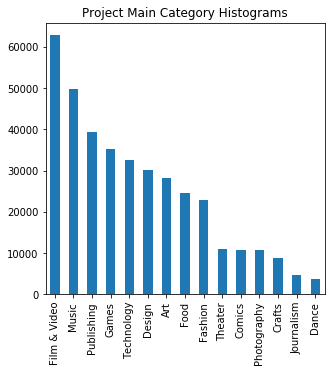

In [21]:
kickproj.groupby(['main_category']).size().reset_index(name='counts')
kickproj['main_category'].value_counts().plot(kind='bar', title='Project Main Category Histograms')

In [22]:
cateDF = kickproj.groupby(['main_category', 'category']).size().reset_index(name='counts')
len(cateDF)
cateDF.head(40)

170

,main_category,category,counts
0,Art,Art,8253
1,Art,Ceramics,305
2,Art,Conceptual Art,1030
3,Art,Digital Art,1346
4,Art,Illustration,3175
5,Art,Installations,482
6,Art,Mixed Media,2757
7,Art,Painting,3294
8,Art,Performance Art,2154
9,Art,Public Art,3077


,country,counts
0,AT,597
1,AU,7839
2,BE,617
3,CA,14756
4,CH,761
5,DE,4171
6,DK,1113
7,ES,2276
8,FR,2939
9,GB,33672


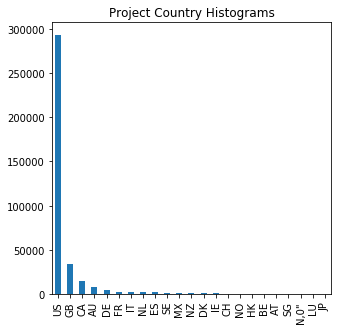

In [23]:
kickproj.groupby(['country']).size().reset_index(name='counts')
kickproj['country'].value_counts().plot(kind='bar', title='Project Country Histograms')

### Remove country with invalid value, N,0"

,country,counts
0,AT,597
1,AU,7839
2,BE,617
3,CA,14756
4,CH,761
5,DE,4171
6,DK,1113
7,ES,2276
8,FR,2939
9,GB,33672


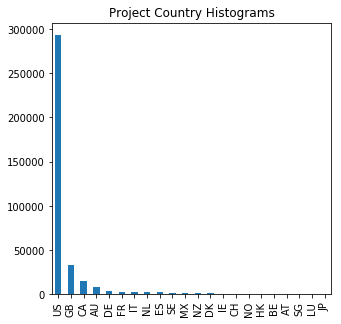

In [24]:
kickproj = kickproj[kickproj['country'] != 'N,0"']
kickproj.groupby(['country']).size().reset_index(name='counts')
kickproj['country'].value_counts().plot(kind='bar', title='Project Country Histograms')

### Check null value 

In [25]:
null_columns=kickproj.columns[kickproj.isnull().any()]
null_columns
kickproj[null_columns].isnull().sum()
kickproj[kickproj["name"].isnull()][null_columns] 

Index([u'name'], dtype='object')

name    4
dtype: int64

,name
166851,NaN
307234,NaN
309991,NaN
338931,NaN


### Replace nan with Unknow for name

In [26]:
kickproj["name"].fillna('Unknown', inplace=True)
null_columns=kickproj.columns[kickproj.isnull().any()]
null_columns

Index([], dtype='object')

### Apply correct data types to DataFrame:

In [27]:
print 'Data types do not align with the data types defined in the data dictionary:\n\n', kickproj.dtypes

Data types do not align with the data types defined in the data dictionary:

ID                    int64
name                 object
category             object
main_category        object
currency             object
deadline             object
launched             object
state                object
backers               int64
country              object
usd_pledged_real    float64
usd_goal_real       float64
dtype: object


In [28]:
# Columns that are of date data type:
datecols = ['deadline','launched']
# Columns that are of int data type:
intcols = ['usd_pledged_real','usd_goal_real']

for col in datecols:
    kickproj[col] = pd.to_datetime(kickproj[col])
    kickproj[col] = [d.date().toordinal() for d in kickproj[col]]
# Convert date columns to date data type:
#kickproj[datecols] = kickproj[datecols].applymap(pd.to_datetime).applymap(lambda x: x.date()).applymap(pd.to_datetime)
# Convert int columns to int data type:
kickproj[intcols] = kickproj[intcols].fillna(0).astype(np.int64)

In [29]:
print 'Review converted data types:\n\n', kickproj.dtypes

Review converted data types:

ID                   int64
name                object
category            object
main_category       object
currency            object
deadline             int64
launched             int64
state               object
backers              int64
country             object
usd_pledged_real     int64
usd_goal_real        int64
dtype: object


### Find out correlation among variables

In [30]:
kickproj.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)

,ID,name,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real
ID,1.000000,0.991679,-0.001201,0.003264,-0.000385,0.010488,0.010688,-0.002991,0.025643,-0.000765,0.122603,0.100961
name,0.991679,1.000000,-0.001672,0.004811,-0.000059,0.010610,0.010534,-0.002681,0.026743,-0.000443,0.123621,0.100064
category,-0.001201,-0.001672,1.000000,0.241871,0.038197,-0.055080,-0.051762,-0.019788,-0.057290,0.038330,-0.067989,0.031169
main_category,0.003264,0.004811,0.241871,1.000000,0.075304,-0.038902,-0.047544,-0.023371,0.027028,0.076911,0.010795,0.071723
currency,-0.000385,-0.000059,0.038197,0.075304,1.000000,-0.018479,-0.021705,-0.033297,-0.011419,0.944815,-0.003260,0.350583
deadline,0.010488,0.010610,-0.055080,-0.038902,-0.018479,1.000000,0.304481,0.046086,-0.006135,-0.019514,0.000498,-0.033184
launched,0.010688,0.010534,-0.051762,-0.047544,-0.021705,0.304481,1.000000,0.038582,-0.019554,-0.022924,-0.012453,-0.033836
state,-0.002991,-0.002681,-0.019788,-0.023371,-0.033297,0.046086,0.038582,1.000000,0.316839,-0.029949,0.431061,-0.065191
backers,0.025643,0.026743,-0.057290,0.027028,-0.011419,-0.006135,-0.019554,0.316839,1.000000,-0.010413,0.568050,0.009392
country,-0.000765,-0.000443,0.038330,0.076911,0.944815,-0.019514,-0.022924,-0.029949,-0.010413,1.000000,0.000752,0.347599


In [31]:
def roundup(x, y):
    #return int(math.ceil(x / float(y))) * y
    return int(math.ceil(float(x) / float(y)) * y)
binrange = range(1, roundup(max(kickproj['usd_pledged_real']),100000), 5000000)
binrange

[1, 5000001, 10000001, 15000001, 20000001]

In [32]:
min(kickproj['usd_goal_real'])
max(kickproj['usd_goal_real'])

0

166361390

In [33]:
# All successful records have usd_pledged_real > 0
min(kickproj['usd_pledged_real'])
max(kickproj['usd_pledged_real'])

kickproj[(kickproj['usd_pledged_real']==0) & (kickproj['state']=='successful')]

0

20338986

,ID,name,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real
232312,250850561,What Toodoo based on current weather conditions,Technology,Technology,CAD,735685,735625,successful,1,CA,0,0


#### Create Projects Summary DataFrame:

In [34]:
kickproj_summary = kickproj.groupby(['main_category','state'], as_index=False) \
[['usd_goal_real','usd_pledged_real','backers']].agg({
    'usd_goal_real':[np.sum, np.mean, np.std],
    'usd_pledged_real':[np.sum, np.mean, np.std],
    'backers':[np.sum, np.mean, np.std,'count']
})

#"Flatten" summary results:
kickproj_summary.columns = list(map('_'.join, kickproj_summary.columns.values))

#Rename a few columns:
kickproj_summary.columns.values[-1] = 'project_count'
kickproj_summary.columns.values[0] = 'main_category'
kickproj_summary.columns.values[1] = 'state'

kickproj_summary.head()

,main_category,state,usd_goal_real_sum,usd_goal_real_mean,usd_goal_real_std,usd_pledged_real_sum,usd_pledged_real_mean,usd_pledged_real_std,backers_sum,backers_mean,backers_std,project_count
0,Art,canceled,88606593,39876.954545,4.895348e+05,1082902,487.354635,1913.420167,16127,7.257876,24.230278,2222
1,Art,failed,960317816,67958.234803,1.840814e+06,8831025,624.939849,2890.981476,124655,8.821386,28.250023,14131
2,Art,live,2989653,15410.582474,8.691543e+04,463699,2390.201031,13561.788361,6271,32.324742,155.476279,194
3,Art,successful,50759075,4409.997828,1.027395e+04,80244909,6971.755778,33621.781341,1040022,90.358123,325.885620,11510
4,Art,suspended,881418,9181.437500,3.284727e+04,54835,571.197917,2335.840102,1125,11.718750,53.503311,96


#### Data Visualization

from ggplot import *

ggplot(kickproj, aes(x='backers', y='usd_pledged_real', color='state')) +\
    geom_point(size=20) +\
    xlab('backers') + ylab('usd_pledged_real') + ggtitle('Backers v. Pledged\nFaceted by Project State') +\
    scale_x_continuous(limits=(0,max(kickproj.backers))) +\
    scale_y_continuous(limits=(0,max(kickproj.usd_pledged_real))) +\
    theme_bw() +\
    facet_grid('state')    

fig=plt.figure(figsize=(16, 16), dpi= 100, facecolor='w', edgecolor='k')

ggplot(kickproj[(kickproj['state'] =='successful')], aes(x='backers', y='usd_pledged_real', color='state')) +\
    geom_point(size=20) +\
    xlab('backers') + ylab('usd_pledged_real') + ggtitle('Backers v. Pledged\nState is equal to Successful') +\
    scale_x_continuous(limits=(0,150000),labels='comma') +\
    scale_y_continuous(limits=(0,max(kickproj.usd_pledged_real)),labels='comma') +\
    theme_bw() 

In [35]:
shffled_kickproj = kickproj.sample(frac=1)

In [36]:
#df['c'] = df.apply(lambda row: row.a + row.b, axis=1)
shffled_kickproj['state_cd'] = shffled_kickproj['state'].apply(lambda a: True if a == 'successful' else False)
shffled_kickproj.head(5)

,ID,name,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real,state_cd
327700,738943453,IvoryBoards - High Quality Affordable Electric...,Hardware,Technology,AUD,736411,736390,successful,69,AU,53820,38095,True
341055,807146557,After Carpathia: The Conceptual Sequel to Titanic,Theater,Theater,USD,734796,734770,failed,31,US,1365,10000,False
236367,271593755,"Sex, Love & Food",Fiction,Publishing,USD,735223,735193,failed,1,US,1,5000,False
74810,1381178658,Revels SummerFaire 2012,World Music,Music,USD,734672,734652,successful,60,US,3775,3500,True
313559,667039333,Schubert: Der Wanderer,Theater,Theater,GBP,736012,735976,successful,12,GB,406,356,True


In [37]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(shffled_kickproj['country'])
shffled_kickproj['country_cd'] = le.transform(shffled_kickproj['country'])
shffled_kickproj.head(5)

LabelEncoder()

,ID,name,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real,state_cd,country_cd
327700,738943453,IvoryBoards - High Quality Affordable Electric...,Hardware,Technology,AUD,736411,736390,successful,69,AU,53820,38095,True,1
341055,807146557,After Carpathia: The Conceptual Sequel to Titanic,Theater,Theater,USD,734796,734770,failed,31,US,1365,10000,False,21
236367,271593755,"Sex, Love & Food",Fiction,Publishing,USD,735223,735193,failed,1,US,1,5000,False,21
74810,1381178658,Revels SummerFaire 2012,World Music,Music,USD,734672,734652,successful,60,US,3775,3500,True,21
313559,667039333,Schubert: Der Wanderer,Theater,Theater,GBP,736012,735976,successful,12,GB,406,356,True,9


In [38]:
num = shffled_kickproj.shape[0]/2

train_x, train_y = shffled_kickproj.iloc[0:num, [5,6,8,9,10,11,13]], shffled_kickproj.iloc[0:num, 12]
test_x, test_y = shffled_kickproj.iloc[num:, [5,6,8,9,10,11,13]], shffled_kickproj.iloc[num:, 12]
train_x.head(2)
train_x.shape
train_y.head(2)
train_y.shape
test_x.head(2)
test_x.shape
test_y.head(2)
test_y.shape

,deadline,launched,backers,country,usd_pledged_real,usd_goal_real,country_cd
327700,736411,736390,69,AU,53820,38095,1
341055,734796,734770,31,US,1365,10000,21


(187432, 7)

327700     True
341055    False
Name: state_cd, dtype: bool

(187432,)

,deadline,launched,backers,country,usd_pledged_real,usd_goal_real,country_cd
92222,734989,734959,5,US,161,5000,21
348489,735155,735120,142,CA,5633,3399,3


(187432, 7)

92222     False
348489     True
Name: state_cd, dtype: bool

(187432,)

### Train training set

In [39]:
temp_features_train = train_x['country_cd'].reshape(-1, 1) # Needs to be the correct shape
temp_features_test = test_x['country_cd'].reshape(-1, 1) # Needs to be the correct shape

/Users/rebeccatung/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.
/Users/rebeccatung/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [40]:
ohe = preprocessing.OneHotEncoder(sparse=False) #Easier to read
#fit on training set only
ohe.fit(temp_features_train)
countryDF_train = DataFrame(ohe.transform(temp_features_train), columns = ohe.active_features_, index = train_x.index)
countryDF_test = DataFrame(ohe.transform(temp_features_test), columns = ohe.active_features_, index = test_x.index)
countryDF_train.head(10)
countryDF_test.head(10)

OneHotEncoder(categorical_features='all', dtype=<type 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=False)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
327700,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
341055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
236367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
74810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
313559,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
240753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
152245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
35136,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
181706,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
25789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
92222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
348489,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
376694,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
270466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
309289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
292047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
54294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
351090,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
374544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
64029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [41]:
train_x.shape
countryDF_train.shape
test_x.shape
countryDF_test.shape

(187432, 7)

(187432, 22)

(187432, 7)

(187432, 22)

In [42]:
train_X1 = pd.merge(train_x.drop(['country','country_cd'], axis=1), countryDF_train, left_index=True, right_index=True)
train_X1.head(10)

test_X1 = pd.merge(test_x.drop(['country','country_cd'], axis=1), countryDF_test, left_index=True, right_index=True)
test_X1.head(10)

,deadline,launched,backers,usd_pledged_real,usd_goal_real,0,1,2,3,4,...,12,13,14,15,16,17,18,19,20,21
327700,736411,736390,69,53820,38095,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
341055,734796,734770,31,1365,10000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
236367,735223,735193,1,1,5000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
74810,734672,734652,60,3775,3500,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
313559,736012,735976,12,406,356,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
240753,734781,734751,2,150,10000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
152245,734124,734063,11,485,5500,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
35136,736605,736560,23,2585,50000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
181706,736641,736618,109,5327,4000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
25789,736383,736353,237,18101,5699,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


,deadline,launched,backers,usd_pledged_real,usd_goal_real,0,1,2,3,4,...,12,13,14,15,16,17,18,19,20,21
92222,734989,734959,5,161,5000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
348489,735155,735120,142,5633,3399,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
376694,735488,735453,2,20,7500,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
270466,735952,735922,0,0,10000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
309289,734475,734450,60,4460,4000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
292047,735388,735382,4,302,2500,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
54294,734205,734115,1,20,500,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
351090,734413,734383,19,1315,7500,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
374544,734604,734547,0,0,25000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
64029,735638,735605,232,13888,13421,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [43]:
result_Dic = {}
#Call function to run KNeighborsClassifier with different n_neighbors settings (up to 20) and store the f1 score results
result_Dic = runKNN(train_X1, train_y.values.ravel(), test_X1, test_y.values.ravel(), 18, trainSetName = 'Basic&Country', dic_result_knn = result_Dic)

In [44]:
#Call function to run LogisticRegression with different class_weight settings (None or Balance)  and store the f1 score results
result_Dic = runLogistic(train_X1, train_y.values.ravel(), test_X1, test_y.values.ravel(), trainSetName = 'Basic&Country', dic_result_log = result_Dic)

In [45]:
# Call function to run LogisticSVM with different kernel settings (linear, rbf or poly)  and store the f1 score results
# result_Dic = runSVM(train_X1, train_y.values.ravel(), test_X1, test_y.values.ravel(), trainSetName = 'Basic&Country', dic_result_log = result_Dic)

In [46]:
#Store number of classes
n_classes = np.unique(shffled_kickproj['state_cd'])
n_classes
resultDF = formatResult(result_Dic, np.append(n_classes, 'micro'))
resultDF.head(10)

array([False,  True], dtype=bool)

,False,True,micro,Sum of Class F1
N=5-Basic&Country,1.00,0.99,0.99,2.98
N=15-Basic&Country,0.99,0.99,0.99,2.97
N=11-Basic&Country,1.00,0.99,0.99,2.98
N=13-Basic&Country,0.99,0.99,0.99,2.97
N=3-Basic&Country,1.00,0.99,0.99,2.98
N=17-Basic&Country,0.99,0.99,0.99,2.97
CWeight = None - Basic&Country,0.98,0.97,0.98,2.93
N=7-Basic&Country,1.00,0.99,0.99,2.98
CWeight = balanced - Basic&Country,0.97,0.94,0.96,2.87
N=9-Basic&Country,1.00,0.99,0.99,2.98


In [47]:
# Print out the top 10 Micro (overall) F1 score from all settings
resultDF.drop('sum').nlargest(5, 'micro')
resultDF.drop('sum').nlargest(5, 'Sum of Class F1')

,False,True,micro,Sum of Class F1
N=5-Basic&Country,1.00,0.99,0.99,2.98
N=15-Basic&Country,0.99,0.99,0.99,2.97
N=11-Basic&Country,1.00,0.99,0.99,2.98
N=13-Basic&Country,0.99,0.99,0.99,2.97
N=3-Basic&Country,1.00,0.99,0.99,2.98


,False,True,micro,Sum of Class F1
N=5-Basic&Country,1.0,0.99,0.99,2.98
N=11-Basic&Country,1.0,0.99,0.99,2.98
N=3-Basic&Country,1.0,0.99,0.99,2.98
N=7-Basic&Country,1.0,0.99,0.99,2.98
N=9-Basic&Country,1.0,0.99,0.99,2.98
